<a href="https://colab.research.google.com/github/Khik2219/Cryptocurrency-Price-Forecasting-Using-Hybrid-Models/blob/main/ARIMA%2C_XGBoost%2C_Updated_LTSM%2C_Baseline_and_HybridModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
!pip install -q yfinance ta pandas numpy scikit-learn statsmodels \
                 xgboost==1.7.6 tensorflow==2.18.0 tqdm

#  Data prep: engineer a few TA features


In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import pandas as pd, numpy as np, ta

df = pd.read_csv("https://raw.githubusercontent.com/Khik2219/Cryptocurrency-Price-Forecasting-Using-Hybrid-Models/main/Data/kaggle_cryptoOHLC_dataset.csv")
print("Initial shape:", df.shape)
print("First few rows:")
display(df.head())

# Convert 'date' column to datetime & set as index if it exists
if 'date' in df.columns:
    df['date'] = pd.to_datetime(df['date'])
    df.set_index('date', inplace=True)

print("\nData info after setting index (if applicable):")
display(df.info())


# ====== STEP 2: BASIC CLEANING ======
# Drop unneeded columns
for col in ['Unnamed: 0','timestamp']:
    if col in df.columns:
        df.drop(columns=[col], inplace=True)

# Keep only Bitcoin (if crypto_name column is present)
if 'crypto_name' in df.columns:
    df = df[df['crypto_name'] == 'Bitcoin']
    df.drop(columns=['crypto_name'], inplace=True)

# Interpolate missing values
df.interpolate(method='linear', inplace=True)

# Drop rows that still have NaNs if any remain
df.dropna(inplace=True)
print("\nData shape after cleaning:", df.shape)


Initial shape: (72946, 10)
First few rows:


,Unnamed: 0,open,high,low,close,volume,marketCap,timestamp,crypto_name,date
0,0,112.900002,118.800003,107.142998,115.910004,0.0,1.288693e+09,2013-05-05T23:59:59.999Z,Bitcoin,2013-05-05
1,1,3.493130,3.692460,3.346060,3.590890,0.0,6.229819e+07,2013-05-05T23:59:59.999Z,Litecoin,2013-05-05
2,2,115.980003,124.663002,106.639999,112.300003,0.0,1.249023e+09,2013-05-06T23:59:59.999Z,Bitcoin,2013-05-06
3,3,3.594220,3.781020,3.116020,3.371250,0.0,5.859436e+07,2013-05-06T23:59:59.999Z,Litecoin,2013-05-06
4,4,112.250000,113.444000,97.699997,111.500000,0.0,1.240594e+09,2013-05-07T23:59:59.999Z,Bitcoin,2013-05-07



Data info after setting index (if applicable):
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 72946 entries, 2013-05-05 to 2022-10-23
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   72946 non-null  int64  
 1   open         72946 non-null  float64
 2   high         72946 non-null  float64
 3   low          72946 non-null  float64
 4   close        72946 non-null  float64
 5   volume       72946 non-null  float64
 6   marketCap    72946 non-null  float64
 7   timestamp    72946 non-null  object 
 8   crypto_name  72946 non-null  object 
dtypes: float64(6), int64(1), object(2)
memory usage: 5.6+ MB


None


Data shape after cleaning: (3248, 6)


In [22]:
# ====== STEP 4: FEATURE ENGINEERING ======
# We'll add some simple features: moving averages & daily returns.
# Adjust or remove if your dataset doesn't have these.

df['SMA_7'] = df['close'].rolling(window=7).mean()
df['SMA_30'] = df['close'].rolling(window=30).mean()
df['Daily_Return'] = df['close'].pct_change()
df.dropna(inplace=True)  # remove any NaNs introduced by rolling

print("Data after feature engineering:")
display(df.head())


Data after feature engineering:


,open,high,low,close,volume,marketCap,SMA_7,SMA_30,Daily_Return
date,,,,,,,,,
2013-06-03,122.500000,122.500000,116.000000,122.222000,0.0,1.373708e+09,127.559000,122.037966,-0.000572
2013-06-04,120.737000,123.839996,119.099998,121.419998,0.0,1.365338e+09,126.476143,122.221633,-0.006562
2013-06-05,121.400002,123.469002,119.899002,121.650002,0.0,1.368486e+09,124.954714,122.533299,0.001894
2013-06-06,121.900002,123.099998,117.250000,118.000000,0.0,1.327960e+09,123.412000,122.749966,-0.030004
2013-06-07,118.970001,119.000000,106.419998,111.500000,0.0,1.255259e+09,120.912000,122.681099,-0.055085


In [23]:
# ====== STEP 5: SCALING THE DATA ======
# LSTM models often benefit from normalization or scaling of inputs.
# We'll use MinMaxScaler on relevant columns.

scaler = MinMaxScaler(feature_range=(0,1))

# Select columns for scaling (adjust as needed)
scale_cols = ['open','high','low','close','SMA_7','SMA_30','Daily_Return']
scale_cols = [c for c in scale_cols if c in df.columns]  # ensure they exist

df[scale_cols] = scaler.fit_transform(df[scale_cols])

print("First few rows after scaling:")
display(df.head())

First few rows after scaling:


,open,high,low,close,volume,marketCap,SMA_7,SMA_30,Daily_Return
date,,,,,,,,,
2013-06-03,0.000800,0.000698,0.000761,0.000797,0.0,1.373708e+09,0.000805,0.000526,0.463107
2013-06-04,0.000774,0.000717,0.000808,0.000785,0.0,1.365338e+09,0.000789,0.000529,0.455633
2013-06-05,0.000784,0.000712,0.000820,0.000788,0.0,1.368486e+09,0.000765,0.000534,0.466185
2013-06-06,0.000791,0.000706,0.000780,0.000734,0.0,1.327960e+09,0.000742,0.000537,0.426381
2013-06-07,0.000748,0.000647,0.000617,0.000638,0.0,1.255259e+09,0.000704,0.000536,0.395084


In [24]:
# ====== STEP 6: PREPARE SEQUENCES FOR LSTM ======
# We'll predict the "next day's close" using the previous N days of features.
# Let's define a helper function to build sequences of length N.

sequence_length = 30  # how many past days to include in each sequence?

def create_sequences(data, target, seq_length):
    """
    data: NumPy array of shape (num_samples, num_features)
    target: NumPy array of the 'close' or next-day price to predict
    seq_length: how many time steps per sample
    Returns:
       X_seq, y_seq (both are arrays)
    """
    Xs, ys = [], []
    for i in range(len(data) - seq_length):
        Xs.append(data[i:i+seq_length])
        ys.append(target[i+seq_length])
    return np.array(Xs), np.array(ys)

# We'll define our feature set (X) and target (Y)
# Our target is still the actual "close" price, but shifted by 1 day in the create_sequences logic.

features = ['open','high','low','close','SMA_7','SMA_30','Daily_Return']
features = [f for f in features if f in df.columns]  # safety check

X_raw = df[features].values
y_raw = df['close'].values  # we want to predict 'close'

X_seq, y_seq = create_sequences(X_raw, y_raw, sequence_length)
print("X_seq shape:", X_seq.shape)
print("y_seq shape:", y_seq.shape)


print("Train sequences:", X_train_seq.shape, "Test sequences:", X_test_seq.shape)

X_seq shape: (3189, 30, 7)
y_seq shape: (3189,)
Train sequences: (2551, 30, 7) Test sequences: (638, 30, 7)


In [33]:
# ======= STEP 7 : UNIVERSAL SPLIT + BASELINES + FINAL LSTM =======

# 1️⃣ Choose ONE cut-off date (80 % into original df)
split_ratio = 0.80
split_loc   = int(len(df) * split_ratio)
split_date  = df.index[split_loc]          # df must already have DateTimeIndex
print(f"split_date = {split_date.date()}  (≈{split_ratio*100:.0f}% train)")

# 2️⃣ BASELINES built on raw series
y_true_full = df["close"]
baseline_preds = {
    "naïve_shift1": y_true_full.shift(1),
    "mean_3":       y_true_full.rolling(3).mean().shift(1),
    "linear_3":     2*y_true_full.shift(1) - y_true_full.shift(4),
}

for k in baseline_preds:
    baseline_preds[k] = baseline_preds[k].loc[split_date:].dropna()
y_test_raw = y_true_full.loc[split_date:].dropna()

# 3️⃣ LSTM sequences split by SAME date
target_indices = np.arange(sequence_length, len(df))
seq_dates      = df.index[target_indices]
train_mask     = seq_dates < split_date
test_mask      = ~train_mask

X_train_seq, X_test_seq = X_seq[train_mask], X_seq[test_mask]
y_train_seq, y_test_seq = y_seq[train_mask], y_seq[test_mask]
print(f"Sequences → Train: {X_train_seq.shape}, Test: {X_test_seq.shape}")

# 4️⃣ Build + train BEST LSTM (32 units) with ES
best_model = Sequential([
    Input(shape=(sequence_length, len(features))),
    LSTM(64),
    Dropout(0.2),
    Dense(1)
])
best_model.compile(loss="mse", optimizer=Adam(1e-3))
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=5, restore_best_weights=True, verbose=0
)
best_model.fit(
    X_train_seq, y_train_seq,
    epochs          = 100,
    batch_size      = 32,
    validation_split= 0.1,
    callbacks       = [early_stop],
    verbose         = 0
)
lstm_preds = best_model.predict(X_test_seq, verbose=0).flatten()

from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np, pandas as pd
def rmse(a,b): return np.sqrt(mean_squared_error(a,b))

results = []
for name, p in baseline_preds.items():
    aligned_y = y_test_raw.loc[p.index]
    results.append({"model": name,
                    "MSE" : mean_squared_error(aligned_y, p),
                    "RMSE": rmse(aligned_y, p),
                    "MAE":  mean_absolute_error(aligned_y, p)})

results.append({"model": "LSTM_32u",
                "MSE" : mean_squared_error(y_test_seq, lstm_preds),
                "RMSE": rmse(y_test_seq, lstm_preds),
                "MAE":  mean_absolute_error(y_test_seq, lstm_preds)})

results_df = pd.DataFrame(results).sort_values("RMSE")
display(results_df)


split_date = 2020-06-25  (≈80% train)
Sequences → Train: (2545, 30, 7), Test: (644, 30, 7)


,model,MSE,RMSE,MAE
0,naïve_shift1,0.000603,0.024561,0.016326
1,mean_3,0.000896,0.029930,0.020882
2,linear_3,0.002331,0.048279,0.034182
3,LSTM_32u,0.008330,0.091268,0.069910


In [34]:
# ======= STEP 7b: MODEL-SIZE SWEEP & COMPARISON =======
#
# Using smaller LTSM models to see if bigger models are really better
#
# It will print a small table summarising each model’s test-set RMSE & MAE.

import pandas as pd
import tensorflow as tf
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

def build_lstm(units: int) -> Sequential:
    """Return a 1-layer LSTM → Dense(1) regressor with `units` cells."""
    model = Sequential([
        Input(shape=(sequence_length, len(features))),
        LSTM(units, return_sequences=False),
        Dropout(0.2),
        Dense(1)                      # next-day close prediction
    ])
    model.compile(loss="mse", optimizer=Adam(1e-3))
    return model

units_list   = [8, 16, 32, 64]         # ← tweak as desired
n_epochs     = 15                       # small for sweep
batch_size   = 32
val_split    = 0.1
results      = []

for u in units_list:
    print(f"\n Training LSTM with {u} units")
    model = build_lstm(u)

    history = model.fit(
        X_train_seq, y_train_seq,
        epochs          = n_epochs,
        batch_size      = batch_size,
        validation_split= val_split,
        verbose         = 0
    )

    # --- evaluate on shared test set ---
    preds      = model.predict(X_test_seq, verbose=0)
    mse        = mean_squared_error(y_test_seq, preds)
    rmse       = np.sqrt(mean_squared_error(y_test_seq, preds))
    mae        = mean_absolute_error(y_test_seq, preds)
    val_final  = history.history["val_loss"][-1]

    results.append({"units": u,
                    "val_loss_last_epoch": val_final,
                    "test_MSE": mse,
                    "test_RMSE": rmse,
                    "test_MAE": mae})

# ---- tidy summary table ----
summary_df = pd.DataFrame(results)
display(summary_df.sort_values("units"))



 Training LSTM with 8 units

 Training LSTM with 16 units

 Training LSTM with 32 units

 Training LSTM with 64 units


,units,val_loss_last_epoch,test_MSE,test_RMSE,test_MAE
0,8,0.000085,0.034373,0.185400,0.145952
1,16,0.000044,0.005802,0.076170,0.059283
2,32,0.000100,0.012918,0.113657,0.093507
3,64,0.000056,0.007796,0.088293,0.070885


,model,MSE,RMSE,MAE
0,naïve_shift1,0.000603,0.024561,0.016326
1,mean_3,0.000896,0.029930,0.020882
2,linear_3,0.002331,0.048279,0.034182
3,LSTM_32u,0.008330,0.091268,0.069910


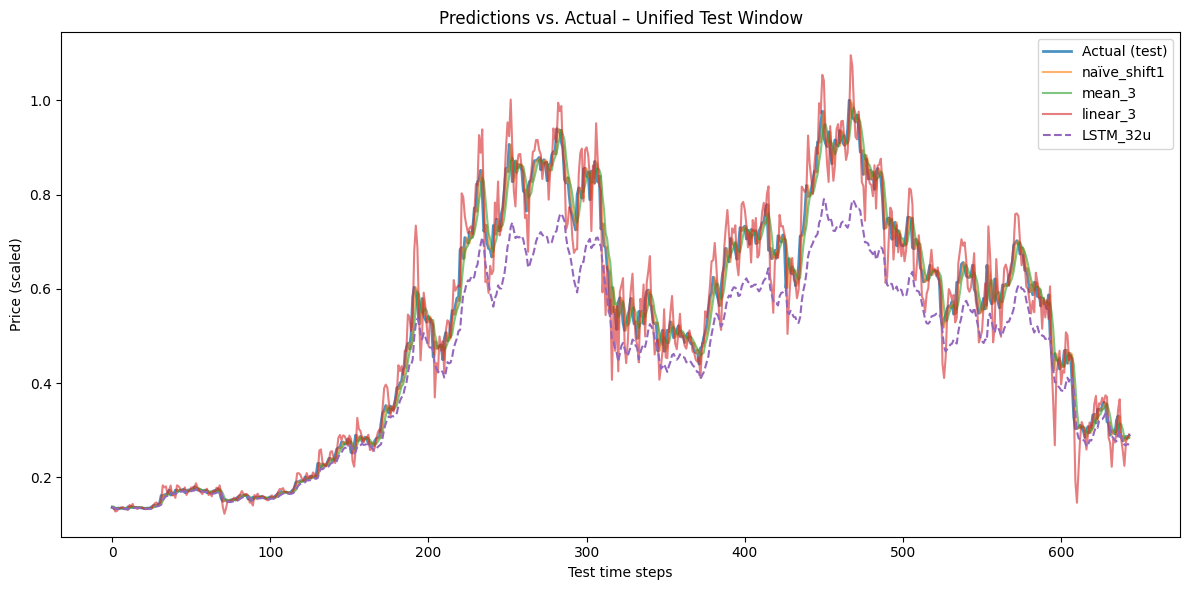

In [35]:
# ====== STEP 8 : COMPARATIVE EVALUATION & PLOT ======

import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np, pandas as pd

# --------------------------------------------------
# 1) Collect predictions in one dict  {name: Series or array}
# --------------------------------------------------
# Baselines were already sliced to split_date and stored in `baseline_preds`
models = {
    "naïve_shift1" : baseline_preds["naïve_shift1"],
    "mean_3"       : baseline_preds["mean_3"],
    "linear_3"     : baseline_preds["linear_3"],
}

# Add the LSTM predictions, but give them the SAME date index
lstm_test_dates          = df.index[sequence_length:][test_mask]   # dates of y_test_seq
models["LSTM_32u"]       = pd.Series(lstm_preds, index=lstm_test_dates)

# Ground-truth for baselines (raw prices) and for LSTM (seq targets)
y_true_series = y_test_raw                     # Series with date index
y_true_array  = y_test_seq                     # NumPy array aligned with lstm_preds

# --------------------------------------------------
# 2) Compute MSE / RMSE / MAE for each model
# --------------------------------------------------
rows = []
for name, pred in models.items():
    if name.startswith("LSTM"):
        y_true = y_true_array                  # already aligned by construction
    else:
        y_true = y_true_series.loc[pred.index] # align on dates
    mse  = mean_squared_error(y_true, pred)
    rmse = np.sqrt(mse)
    mae  = mean_absolute_error(y_true, pred)
    rows.append({"model": name, "MSE": mse, "RMSE": rmse, "MAE": mae})

eval_df = pd.DataFrame(rows).sort_values("RMSE")
display(eval_df)

# --------------------------------------------------
# 3) Overlay plot: actual vs. each model
# --------------------------------------------------
plt.figure(figsize=(12,6))
plt.plot(y_true_array, label="Actual (test)", linewidth=2, alpha=0.8)

for name, pred in models.items():
    if name.startswith("LSTM"):
        plt.plot(pred.values, label=name, linestyle="--")
    else:
        plt.plot(pred.values, label=name, alpha=0.6)

plt.title("Predictions vs. Actual – Unified Test Window")
plt.xlabel("Test time steps")
plt.ylabel("Price (scaled)")
plt.legend()
plt.tight_layout()
plt.show()


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1,1,1)(1,1,1,7) EVALUATION
 MSE  = 0.1915
 RMSE = 0.4377
 MAE  = 0.3636


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


,model,MSE,RMSE,MAE
0,naïve_shift1,0.000603,0.024561,0.016326
1,mean_3,0.000896,0.029930,0.020882
2,linear_3,0.002331,0.048279,0.034182
3,LSTM_32u,0.008330,0.091268,0.069910
4,"ARIMA(1,1,1)(1,1,1,7)",0.191549,0.437663,0.363642


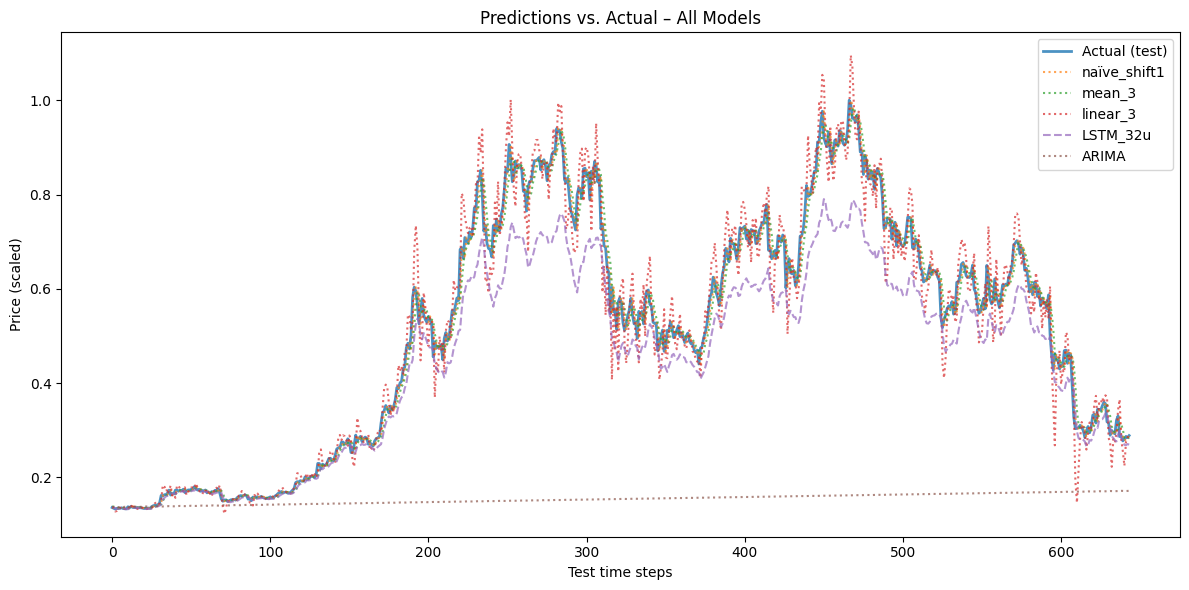

In [37]:
# ====== STEP 8 b : ARIMA BENCHMARK (same split, same metrics) ======

from statsmodels.tsa.statespace.sarimax import SARIMAX

# 1️⃣  Re-use the mask you already created with split_date
train_mask_raw = y_true_full.index < split_date
y_train_ar     = y_true_full.loc[train_mask_raw]   # up-to day *before* split_date
y_test_ar      = y_true_full.loc[~train_mask_raw]  # identical to y_test_raw

# 2️⃣  Fit SARIMA(1,1,1)(1,1,1,7) on the TRAIN window
arima = SARIMAX(
    y_train_ar,
    order=(1,1,1),
    seasonal_order=(1,1,1,7),
    enforce_stationarity=False,
    enforce_invertibility=False
).fit(disp=False)

# 3️⃣  Forecast the TEST window length
pred_arima = arima.forecast(steps=len(y_test_ar))
pred_arima.index = y_test_ar.index          # align indices

# 4️⃣  Same metrics as before
mse_arima  = mean_squared_error(y_test_ar, pred_arima)
rmse_arima = np.sqrt(mse_arima)
mae_arima  = mean_absolute_error(y_test_ar, pred_arima)

print("ARIMA(1,1,1)(1,1,1,7) EVALUATION")
print(f" MSE  = {mse_arima:.4f}")
print(f" RMSE = {rmse_arima:.4f}")
print(f" MAE  = {mae_arima:.4f}")

# 5️⃣  Append to the unified results table you built in Step 8
eval_df = pd.concat([
    eval_df,
    pd.DataFrame([{
        "model": "ARIMA(1,1,1)(1,1,1,7)",
        "MSE":   mse_arima,
        "RMSE":  rmse_arima,
        "MAE":   mae_arima
    }])
]).sort_values("RMSE").reset_index(drop=True)

display(eval_df)

# 6️⃣  (Optional) add ARIMA to the overlay plot
models["ARIMA"] = pred_arima               # <-- re-use dict from Step 8

plt.figure(figsize=(12,6))
plt.plot(y_true_array, label="Actual (test)", linewidth=2, alpha=0.8)

for name, pred in models.items():
    style = "--" if name.startswith("LSTM") else ":"
    plt.plot(pred.values, label=name, linestyle=style, alpha=0.7)

plt.title("Predictions vs. Actual – All Models")
plt.xlabel("Test time steps")
plt.ylabel("Price (scaled)")
plt.legend()
plt.tight_layout()
plt.show()


In [44]:
# ====== STEP 8 c : XGBoost BENCHMARK – clean NaN/inf ======

from xgboost import XGBRegressor
import numpy as np, pandas as pd

def make_lags(series, lags=(1,2,3,7)):
    df_lag = pd.DataFrame(index=series.index)
    for l in lags:
        df_lag[f"lag_{l}"] = series.shift(l)
    df_lag["ret_1d"] = series.pct_change()
    return df_lag

# 1) Build feature frame on full series
daily_close = y_true_full[~y_true_full.index.duplicated(keep="last")]
feat_xgb    = make_lags(daily_close)
feat_xgb["y"] = daily_close.shift(-1)

# 🆕 2)  Replace infinities, then drop any residual NaNs
feat_xgb = feat_xgb.replace([np.inf, -np.inf], np.nan).dropna()

# 3) Split on SAME split_date
train_mask   = feat_xgb.index < split_date
X_train_xgb  = feat_xgb.loc[train_mask].drop(columns="y")
y_train_xgb  = feat_xgb.loc[train_mask,     "y"]
X_test_xgb   = feat_xgb.loc[~train_mask].drop(columns="y")
y_test_xgb   = feat_xgb.loc[~train_mask,    "y"]

# 🆕 4)  Sanity check — should be all finite
assert np.isfinite(X_train_xgb.values).all() and np.isfinite(y_train_xgb.values).all(), "train contains NaN/inf"
assert np.isfinite(X_test_xgb.values).all()  and np.isfinite(y_test_xgb.values).all(),  "test contains NaN/inf"

# 5) Fit model
xgb = XGBRegressor(
        n_estimators     = 600,
        learning_rate    = 0.05,
        max_depth        = 5,
        subsample        = 0.8,
        colsample_bytree = 0.8,
        objective        = "reg:squarederror",
        random_state     = 42,
        n_jobs           = -1
     ).fit(X_train_xgb, y_train_xgb)

pred_xgb = pd.Series(xgb.predict(X_test_xgb), index=X_test_xgb.index)
# 6) ⬅️  **NEW** – record metrics in eval_df
mse_xgb  = mean_squared_error(y_test_xgb, pred_xgb)
rmse_xgb = np.sqrt(mse_xgb)
mae_xgb  = mean_absolute_error(y_test_xgb, pred_xgb)

eval_df = pd.concat([
    eval_df,
    pd.DataFrame([{
        "model": "XGBoost",
        "MSE":   mse_xgb,
        "RMSE":  rmse_xgb,
        "MAE":   mae_xgb
    }])
]).sort_values("RMSE").reset_index(drop=True)

# 7) ⬅️  **NEW** – store for downstream hybrids & plots
models["XGBoost"] = pred_xgb

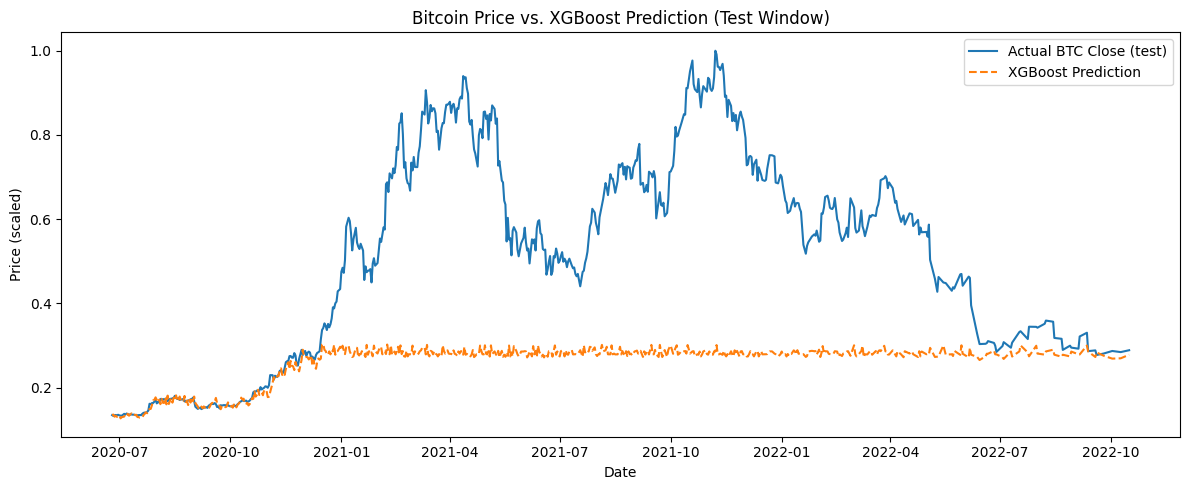

In [45]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming `pred_xgb` and `y_test_xgb` already exist as pandas Series with
# a DateTimeIndex (they were created in the previous XGBoost step).
# If they have different indices, align them on the intersection.
common_index = pred_xgb.index.intersection(y_test_xgb.index)
y_true_plot  = y_test_xgb.loc[common_index]
pred_plot    = pred_xgb.loc[common_index]

plt.figure(figsize=(12, 5))
plt.plot(y_true_plot, label="Actual BTC Close (test)")
plt.plot(pred_plot, linestyle="--", label="XGBoost Prediction")
plt.title("Bitcoin Price vs. XGBoost Prediction (Test Window)")
plt.xlabel("Date")
plt.ylabel("Price (scaled)")
plt.legend()
plt.tight_layout()
plt.show()


In [46]:
# Dates in each split
print("latest train date:", max(y_train_ar.index))
print("earliest test date:", min(y_test_ar.index))

assert max(y_train_ar.index) < min(y_test_ar.index), "Splits overlap!"


latest train date: 2020-06-24 00:00:00
earliest test date: 2020-06-25 00:00:00


Stacking weights (Ridge): [-0.7052 -0.032   1.2895]


,model,MSE,RMSE,MAE
0,naïve_shift1,6.0326e-04,2.4561e-02,1.6326e-02
1,Hybrid_stack,8.6715e-04,2.9447e-02,2.1193e-02
2,mean_3,8.9579e-04,2.9930e-02,2.0882e-02
3,linear_3,2.3309e-03,4.8279e-02,3.4182e-02
4,LSTM_32u,8.3298e-03,9.1268e-02,6.9910e-02
5,Hybrid_weighted,5.4320e-02,2.3307e-01,1.8599e-01
6,Hybrid_mean,8.2753e-02,2.8767e-01,2.3169e-01
7,XGBoost,1.1414e-01,3.3785e-01,2.6299e-01
8,"ARIMA(1,1,1)(1,1,1,7)",1.9155e-01,4.3766e-01,3.6364e-01


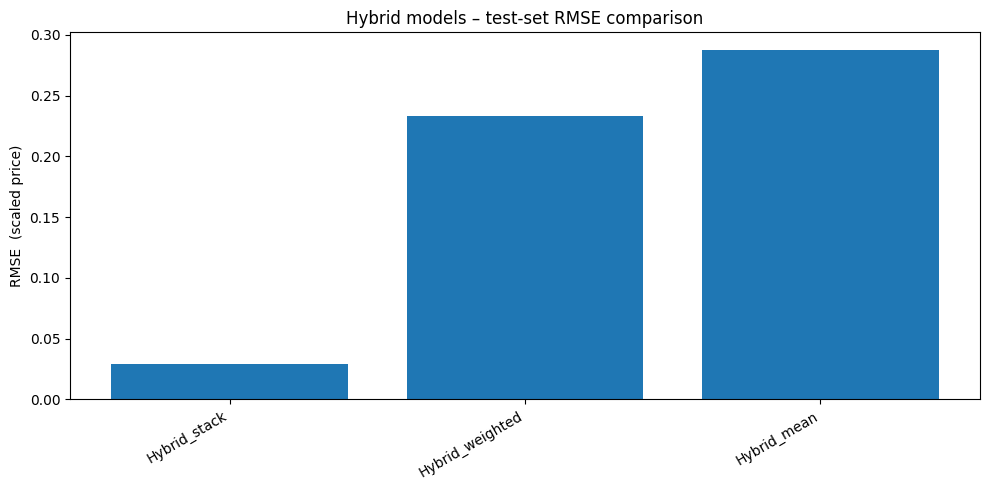

In [47]:
# ====== STEP 8 d : HYBRID ENSEMBLES (same split, same metrics) ======

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_squared_error, mean_absolute_error

# --------------------------------------------------
# 0) Safety checks for required objects
# --------------------------------------------------
required = ["models", "y_test_raw", "eval_df"]
for var in required:
    if var not in globals():
        raise RuntimeError(f"`{var}` not defined – run previous steps first.")

need_keys = ["naïve_shift1", "ARIMA", "XGBoost", "LSTM_32u"]
for k in need_keys:
    if k not in models:
        raise RuntimeError(f"models['{k}'] missing – train that model first.")

# --------------------------------------------------
# 1) Gather COMPONENT predictions (aligned Series)
# --------------------------------------------------
pred_naive = models["naïve_shift1"]
pred_arima = models["ARIMA"]
pred_xgb   = models["XGBoost"]
pred_lstm  = models["LSTM_32u"]

common_idx = pred_naive.index           # all others already share this index

hyb_df = pd.DataFrame({
    "Naive" : pred_naive,
    "ARIMA" : pred_arima.reindex(common_idx),
    "XGB"   : pred_xgb.reindex(common_idx),
    "LSTM"  : pred_lstm.reindex(common_idx),
    "y"     : y_test_raw.reindex(common_idx)
}).dropna(how="any")

# --------------------------------------------------
# 2) Build hybrids
# --------------------------------------------------
# 2a) Simple mean
hyb_df["Hybrid_mean"] = hyb_df[["ARIMA","XGB","LSTM"]].mean(axis=1)

# 2b) Manual weighted average – normalise weights to sum to 1
w = np.array([0.2, 0.3, 0.5], dtype=float)
w = w / w.sum()
hyb_df["Hybrid_weighted"] = hyb_df[["ARIMA","XGB","LSTM"]].values @ w

# 2c) Stacking (RidgeCV)
ridge = RidgeCV(alphas=np.logspace(-3, 3, 25)).fit(
            hyb_df[["ARIMA","XGB","LSTM"]], hyb_df["y"]
        )
hyb_df["Hybrid_stack"] = ridge.predict(hyb_df[["ARIMA","XGB","LSTM"]])
print("Stacking weights (Ridge):", ridge.coef_.round(4))

# --------------------------------------------------
# 3) Evaluate & append to eval_df
# --------------------------------------------------
def row_metrics(name, truth, pred):
    mse  = mean_squared_error(truth, pred)
    rmse = np.sqrt(mse)
    mae  = mean_absolute_error(truth, pred)
    return {"model": name, "MSE": mse, "RMSE": rmse, "MAE": mae}

new_rows = [
    row_metrics("Hybrid_mean",     hyb_df["y"], hyb_df["Hybrid_mean"]),
    row_metrics("Hybrid_weighted", hyb_df["y"], hyb_df["Hybrid_weighted"]),
    row_metrics("Hybrid_stack",    hyb_df["y"], hyb_df["Hybrid_stack"]),
]

eval_df = pd.concat([eval_df, pd.DataFrame(new_rows)]).sort_values("RMSE").reset_index(drop=True)
display(eval_df.style.format({"MSE":"{:.4e}", "RMSE":"{:.4e}", "MAE":"{:.4e}"}))

# --------------------------------------------------
# 4) Add hybrids to models dict
# --------------------------------------------------
models.update({
    "Hybrid_mean":     hyb_df["Hybrid_mean"],
    "Hybrid_weighted": hyb_df["Hybrid_weighted"],
    "Hybrid_stack":    hyb_df["Hybrid_stack"],
})

# --------------------------------------------------
# 5) Graphic – RMSE bar chart of hybrids
# --------------------------------------------------
plt.figure(figsize=(10,5))
hybrid_mask = eval_df["model"].str.startswith("Hybrid")
plt.bar(eval_df.loc[hybrid_mask, "model"],
        eval_df.loc[hybrid_mask, "RMSE"])
plt.ylabel("RMSE  (scaled price)")
plt.title("Hybrid models – test-set RMSE comparison")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()


,model,final_$,return_%
8,Hybrid_stack,"$3,681.04",268.10%
2,linear_3,"$2,718.77",171.88%
0,naïve_shift1,"$2,425.58",142.56%
1,mean_3,"$1,507.55",50.76%
4,ARIMA,"$1,059.14",5.91%
5,XGBoost,"$1,027.30",2.73%
6,Hybrid_mean,$985.32,-1.47%
3,LSTM_32u,$984.54,-1.55%
7,Hybrid_weighted,$969.33,-3.07%


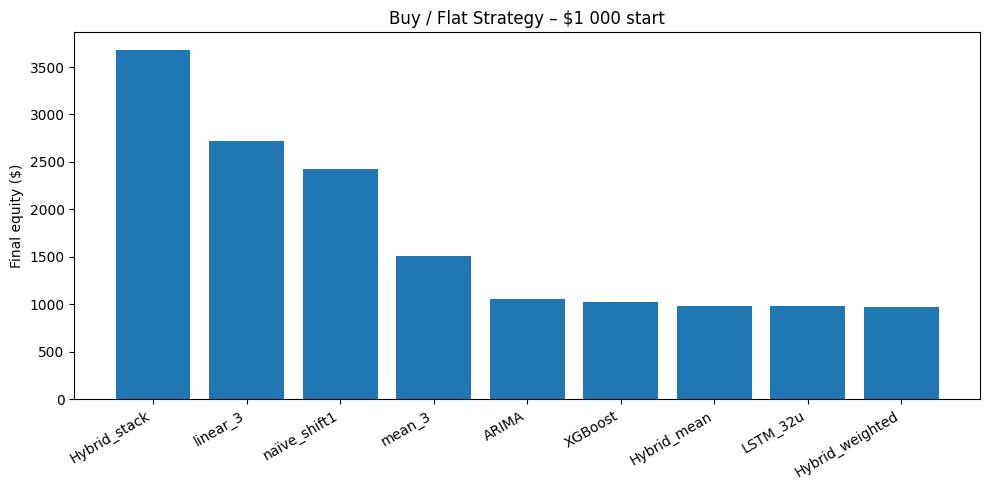

In [49]:
# ====== STEP 9 : Safe Buy/Flat Back-test (skips missing days) ======

INITIAL_CASH = 1_000.0

price = y_test_raw.copy().sort_index()      # ensure ascending

def backtest(pred: pd.Series, price: pd.Series, cash0=INITIAL_CASH):
    """
    If prediction[t] > price[t] ⇒ long for t→t+1, else stay in cash.
    Skips any day where we don’t have t+1 price.
    """
    equity   = cash0
    btc      = 0.0
    curve    = []

    pred = pred.reindex(price.index)        # align, may introduce NaN
    for today, tomorrow in zip(price.index[:-1], price.index[1:]):
        p_today, p_next = price.loc[[today, tomorrow]]

        # Only act if we have a prediction for *today*
        pred_t = pred.loc[today]
        if pd.isna(pred_t):
            curve.append(equity + btc * p_next)
            continue

        if pred_t > p_today:                # bullish → go all-in
            if btc == 0.0:                  # only if not already long
                btc   = equity / p_today
                equity = 0.0
        else:                               # bearish/flat → go cash
            if btc > 0.0:
                equity = btc * p_today
                btc    = 0.0

        curve.append(equity + btc * p_next)

    return curve[-1], pd.Series(curve, index=price.index[1:])

# --------------------------------------------------
# Run every model
# --------------------------------------------------
bt_rows, bt_curves = [], {}
for name, pred in models.items():
    final_equity, curve = backtest(pred, price)
    bt_curves[name] = curve
    bt_rows.append({
        "model"    : name,
        "final_$"  : final_equity,
        "return_%": (final_equity/INITIAL_CASH - 1)*100
    })

bt_df = pd.DataFrame(bt_rows).sort_values("final_$", ascending=False)
display(bt_df.style.format({"final_$":"${:,.2f}", "return_%":"{:.2f}%"}))

# --------------------------------------------------
# Bar chart of results
# --------------------------------------------------
plt.figure(figsize=(10,5))
plt.bar(bt_df["model"], bt_df["final_$"])
plt.ylabel("Final equity ($)")
plt.title("Buy / Flat Strategy – $1 000 start")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()


In [56]:
# =========  BTC SENTIMENT (tab-JSON reader) =========
import os, glob, json, pandas as pd, numpy as np, nltk, tqdm, warnings
from pathlib import Path

# 1) clone repo fresh
!rm -rf /content/CrypTop12
!git clone --quiet --depth 1 https://github.com/am15h/CrypTop12.git /content/CrypTop12

BTC_DIR = Path("/content/CrypTop12/tweet/preprocessed/btc")
btc_files = sorted(glob.glob(str(BTC_DIR / "*")))
print(f"Found {len(btc_files):,} BTC files")

# 2) NLTK VADER
warnings.filterwarnings("ignore")
nltk.download("vader_lexicon", quiet=True)
from nltk.sentiment.vader import SentimentIntensityAnalyzer
vader = SentimentIntensityAnalyzer()

def day_sentiment(path: str):
    """Return 1-row DF with daily sentiment stats, or None on failure."""
    tweets = []
    with open(path, encoding="utf-8") as fh:
        for raw in fh:
            raw = raw.strip()
            if not raw:
                continue
            try:
                obj = json.loads(raw.replace("\t", ", "))
                tok_list = obj.get("text", [])
                tweet = " ".join(str(t) for t in tok_list if t)
                tweets.append(tweet)
            except Exception:
                continue
    if not tweets:
        return None
    scores = [vader.polarity_scores(t)["compound"] for t in tweets]
    return pd.DataFrame({
        "date":      pd.to_datetime(os.path.basename(path)),   # YYYY-MM-DD
        "sent_mean": [np.mean(scores)],
        "sent_std":  [np.std(scores)],
        "sent_pos":  [(np.array(scores) >  0.05).mean()],
        "sent_neg":  [(np.array(scores) < -0.05).mean()],
        "n_tweets":  [len(scores)]
    })

sent_rows, bad = [], 0
for f in tqdm.tqdm(btc_files, desc="Scoring tweets"):
    row = day_sentiment(f)
    if row is not None:
        sent_rows.append(row)
    else:
        bad += 1

print(f"Parsed OK: {len(sent_rows)}  •  Skipped: {bad}")
sentiment_df = pd.concat(sent_rows).set_index("date").sort_index()
display(sentiment_df.head())

# ---------- merge with your OHLC df ----------
# assumes your price DataFrame is named `df`
if "date" in df.columns:
    df["date"] = pd.to_datetime(df["date"])
    df.set_index("date", inplace=True)

df_merged = df.join(sentiment_df, how="inner")
print("Merged shape:", df_merged.shape)
display(df_merged.head())


Found 1,257 BTC files


Scoring tweets: 100%|██████████| 1257/1257 [01:15<00:00, 16.68it/s]


Parsed OK: 1252  •  Skipped: 5


,sent_mean,sent_std,sent_pos,sent_neg,n_tweets
date,,,,,
2017-09-21,-0.035218,0.473742,0.333333,0.348485,66
2017-09-22,0.046162,0.400119,0.397849,0.279570,93
2017-09-23,0.080326,0.378273,0.452381,0.226190,84
2017-09-24,0.131153,0.337247,0.387755,0.163265,49
2017-09-25,0.165891,0.335619,0.459459,0.094595,74


Merged shape: (1240, 14)


,open,high,low,close,volume,marketCap,SMA_7,SMA_30,Daily_Return,sent_mean,sent_std,sent_pos,sent_neg,n_tweets
date,,,,,,,,,,,,,,
2017-09-21,0.056800,0.055910,0.053503,0.052781,1.411480e+09,6.020237e+10,0.056504,0.065880,0.375995,-0.035218,0.473742,0.333333,0.348485,66
2017-09-22,0.052748,0.053608,0.052596,0.052776,1.194830e+09,6.020304e+10,0.056489,0.065601,0.463705,0.046162,0.400119,0.397849,0.279570,93
2017-09-23,0.052776,0.054495,0.053215,0.055171,9.281140e+08,6.289207e+10,0.056855,0.065312,0.519397,0.080326,0.378273,0.452381,0.226190,84
2017-09-24,0.055240,0.054160,0.054306,0.053548,7.680150e+08,6.108197e+10,0.057074,0.064944,0.427772,0.131153,0.337247,0.387755,0.163265,49
2017-09-25,0.053542,0.056402,0.054527,0.057152,1.374210e+09,6.512221e+10,0.056770,0.064716,0.546235,0.165891,0.335619,0.459459,0.094595,74


In [61]:
# =========  SENTIMENT-AWARE MODEL RE-RUN  (MSE + RMSE + MAE)  =========
# Needs: df_merged, split_date, create_sequences() already defined
# ----------------------------------------------------------------------
import numpy as np, pandas as pd, warnings, tensorflow as tf
from sklearn.preprocessing  import MinMaxScaler
from sklearn.metrics        import mean_squared_error, mean_absolute_error
from xgboost                import XGBRegressor
from statsmodels.tsa.statespace.sarimax import SARIMAX
from tensorflow.keras       import Sequential, Input
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.optimizers import Adam

warnings.filterwarnings("ignore")

# 1⃣  FEATURES & SCALING
price_cols = ['open','high','low','close','SMA_7','SMA_30','Daily_Return']
sent_cols  = ['sent_mean','sent_std','sent_pos','sent_neg','n_tweets']
feature_cols = [c for c in price_cols + sent_cols if c in df_merged.columns]

scaler = MinMaxScaler()
df_scaled = df_merged.copy()
df_scaled[feature_cols] = scaler.fit_transform(df_merged[feature_cols])

# 2⃣  SEQUENCES
SEQ_LEN = 30
X_raw = df_scaled[feature_cols].values
y_raw = df_scaled['close'].values
X_seq, y_seq = create_sequences(X_raw, y_raw, SEQ_LEN)

idx = np.arange(SEQ_LEN, len(df_scaled))
seq_dates = df_scaled.index[idx]
train_m   = seq_dates < split_date
test_m    = ~train_m

X_tr_s, X_te_s = X_seq[train_m], X_seq[test_m]
y_tr_s, y_te_s = y_seq[train_m], y_seq[test_m]

# 3⃣  BASELINES
y_full = df_scaled['close']
pred_naive  = y_full.shift(1)
pred_mean3  = y_full.rolling(3).mean().shift(1)
pred_linear = 2*y_full.shift(1) - y_full.shift(4)

# 4⃣  ARIMA
ar_train = y_full.loc[:split_date - pd.Timedelta(days=1)]
ar_test  = y_full.loc[split_date:]
arima = SARIMAX(ar_train, order=(1,1,1), seasonal_order=(1,1,1,7),
                enforce_stationarity=False, enforce_invertibility=False).fit(disp=False)
pred_arima = pd.Series(arima.forecast(len(ar_test)).values, index=ar_test.index)

# 5⃣  LSTM (+ sentiment)
lstm_s = Sequential([
    Input(shape=(SEQ_LEN, len(feature_cols))),
    LSTM(32),
    Dropout(0.2),
    Dense(1)
])
lstm_s.compile(loss="mse", optimizer=Adam(1e-3))
lstm_s.fit(
    X_tr_s, y_tr_s,
    epochs=100, batch_size=32, validation_split=0.1,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)],
    verbose=0
)
pred_lstm = pd.Series(lstm_s.predict(X_te_s, verbose=0).flatten(),
                      index=df_scaled.index[SEQ_LEN:][test_m])
y_lstm_true = pd.Series(y_te_s, index=pred_lstm.index)

# 6⃣  XGBoost (+ sentiment lags)
def make_lags(df, lags=(1,2,3,7)):
    out = pd.DataFrame(index=df.index)
    for l in lags:
        for c in ['close','sent_mean','sent_std']:
            out[f'{c}_lag{l}'] = df[c].shift(l)
    out['ret_1d'] = df['close'].pct_change()
    return out

feat_xgb = make_lags(df_scaled)
feat_xgb['y'] = df_scaled['close'].shift(-1)
feat_xgb = feat_xgb.replace([np.inf,-np.inf], np.nan).dropna()

X_tr  = feat_xgb[feat_xgb.index < split_date].drop(columns='y')
y_tr  = feat_xgb.loc[feat_xgb.index < split_date,'y']
X_te  = feat_xgb[feat_xgb.index >= split_date].drop(columns='y')
y_te  = feat_xgb.loc[feat_xgb.index >= split_date,'y']

xgb_s = XGBRegressor(
    n_estimators=600, learning_rate=0.05, max_depth=5,
    subsample=0.8, colsample_bytree=0.8, objective='reg:squarederror',
    random_state=42, n_jobs=-1
).fit(X_tr, y_tr)
pred_xgb = pd.Series(xgb_s.predict(X_te), index=X_te.index)

# 7⃣  METRICS & COLLECT PREDICTIONS
def metric_row(name, y_true, y_pred, rows, pred_store):
    both = pd.concat([y_true, y_pred], axis=1).dropna()
    if both.empty: return
    y_t, y_p = both.iloc[:,0], both.iloc[:,1]
    mse  = mean_squared_error(y_t, y_p)
    rows.append({"model": name, "MSE": mse,
                 "RMSE": np.sqrt(mse),
                 "MAE":  mean_absolute_error(y_t, y_p)})
    pred_store[name] = y_p            # store aligned preds

rows, preds = [], {}

metric_row("naïve_shift1", y_full, pred_naive,  rows, preds)
metric_row("mean_3",       y_full, pred_mean3,  rows, preds)
metric_row("linear_3",     y_full, pred_linear, rows, preds)
metric_row("ARIMA",        ar_test, pred_arima, rows, preds)
metric_row("LSTM_sent32",  y_lstm_true, pred_lstm, rows, preds)
metric_row("XGB_sent",     y_te,        pred_xgb, rows, preds)

eval_df_sent = pd.DataFrame(rows).sort_values('RMSE').reset_index(drop=True)
display(eval_df_sent.style.format({'MSE':'{:.4e}', 'RMSE':'{:.4f}', 'MAE':'{:.4f}'}))

# keep true-price series for back-test
price_test = y_full.loc[preds['ARIMA'].index[0]:]    # same test window


,model,MSE,RMSE,MAE
0,naïve_shift1,1.3188e-04,0.0115,0.0057
1,mean_3,2.1400e-04,0.0146,0.0075
2,linear_3,5.1243e-04,0.0226,0.0120
3,LSTM_sent32,9.0618e-03,0.0952,0.0519
4,XGB_sent,4.1232e-02,0.2031,0.1040
5,ARIMA,8.4415e-02,0.2905,0.1825


,model,final_$,return_%
6,HODL_BTC,"$106,364.39",10536.44%
0,naïve_shift1,"$22,350.72",2135.07%
2,linear_3,"$6,342.19",534.22%
4,LSTM_sent32,"$2,260.87",126.09%
5,XGB_sent,"$1,635.26",63.53%
3,ARIMA,"$1,071.64",7.16%
7,Stay_Cash,"$1,000.00",0.00%
1,mean_3,$392.96,-60.70%


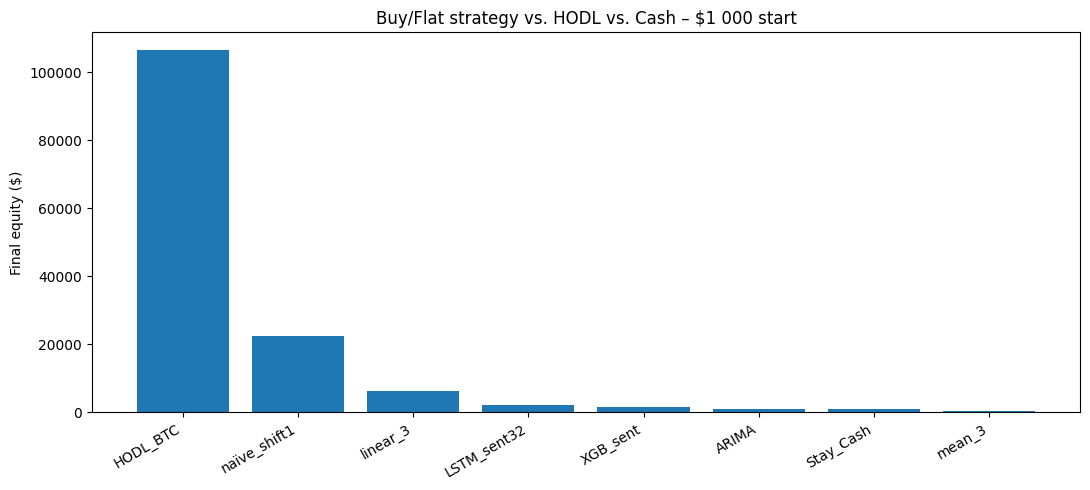

In [64]:
# =========  SIMPLE BUY/FLAT BACK-TEST  +  BENCHMARKS  =========
import matplotlib.pyplot as plt

INITIAL_CASH = 1_000.0
price_full   = y_full          # scaled close-price series with full index

# ------------------------------------------------------------------
# Helper: long-or-cash strategy using next-day prediction
# ------------------------------------------------------------------
def backtest(pred, price):
    idx = pred.index.intersection(price.index)
    if len(idx) < 2:
        return INITIAL_CASH
    equity, btc = INITIAL_CASH, 0.0
    for today in idx[:-1]:
        tomorrow = today + pd.Timedelta(days=1)
        if tomorrow not in price.index:     # skip gaps
            continue
        p_today, p_next = price.loc[[today, tomorrow]]

        if pred.loc[today] > p_today:       # bullish signal
            if equity > 0:
                btc   = equity / p_today
                equity = 0.0
        else:                               # bearish / stay cash
            if btc > 0:
                equity = btc * p_today
                btc    = 0.0

        equity = equity + btc * p_next      # mark-to-market
    return equity

# ------------------------------------------------------------------
# 1) Strategy equity for each model
# ------------------------------------------------------------------
bt_rows = []
for name, series in preds.items():
    equity = backtest(series, price_full)
    bt_rows.append({"model": name,
                    "final_$": equity,
                    "return_%": (equity/INITIAL_CASH - 1)*100})

# ------------------------------------------------------------------
# 2) Baseline: HODL the BTC
# ------------------------------------------------------------------
test_start = min(min(p.index) for p in preds.values())       # earliest pred date
test_end   = max(max(p.index) for p in preds.values())       # latest pred date
p_start, p_end = price_full.loc[[test_start, test_end]]
btc_hodl = INITIAL_CASH / p_start
equity_hodl = btc_hodl * p_end
bt_rows.append({"model": "HODL_BTC",
                "final_$": equity_hodl,
                "return_%": (equity_hodl/INITIAL_CASH - 1)*100})

# ------------------------------------------------------------------
# 3) Baseline: stay in cash
# ------------------------------------------------------------------
bt_rows.append({"model": "Stay_Cash",
                "final_$": INITIAL_CASH,
                "return_%": 0.0})

# ------------------------------------------------------------------
# 4) Results table + bar chart
# ------------------------------------------------------------------
bt_df = pd.DataFrame(bt_rows).sort_values('final_$', ascending=False)
display(bt_df.style.format({'final_$':'${:,.2f}','return_%':'{:.2f}%'}))

plt.figure(figsize=(11,5))
plt.bar(bt_df['model'], bt_df['final_$'])
plt.ylabel("Final equity ($)")
plt.title("Buy/Flat strategy vs. HODL vs. Cash – $1 000 start")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()
